In [ ]:
import numpy as np

def cma_pol_demux_qam(E_in, N_taps=11, mu_CMA=0.01, radii=[np.sqrt(0.2), np.sqrt(1), np.sqrt(1.8)]):
    """
    CMA-based equalizer for QAM with multiple radii (multi-modulus CMA)
    
    E_in : ndarray, shape (N_symbols, 2)
        Input dual-pol signal [X, Y] (complex)
    N_taps : int
        Number of taps per filter
    mu_CMA : float
        CMA step size (learning rate)
    radii : list
        Possible radii of QAM constellation points

    Returns
    -------
    E_out : ndarray, shape (N_symbols, 2)
        Equalized dual-pol output
    taps : dict
        Dictionary with final tap coefficients: pxx, pxy, pyx, pyy
    """
    
    xpol = E_in[:, 0] / np.sqrt(np.mean(np.abs(E_in[:, 0])**2))
    ypol = E_in[:, 1] / np.sqrt(np.mean(np.abs(E_in[:, 1])**2))

    N = len(xpol)

    # Initialize taps
    pxx = np.zeros(N_taps, dtype=complex); pxx[N_taps//2] = 1
    pxy = np.zeros(N_taps, dtype=complex)
    pyx = np.zeros(N_taps, dtype=complex)
    pyy = np.zeros(N_taps, dtype=complex); pyy[N_taps//2] = 1

    xpol = np.concatenate([np.zeros(N_taps-1, dtype=complex), xpol])
    ypol = np.concatenate([np.zeros(N_taps-1, dtype=complex), ypol])

    for ii in range(N_taps-1, len(xpol)):
        # convolution:
        x_vec = xpol[ii-(N_taps-1):ii+1][::-1]
        y_vec = ypol[ii-(N_taps-1):ii+1][::-1]
        
        x_cap = np.vdot(pxx, x_vec) + np.vdot(pxy, y_vec)
        y_cap = np.vdot(pyx, x_vec) + np.vdot(pyy, y_vec)

        # find closest radius before finding error
        R_x = min(radii, key=lambda r: abs(np.abs(x_cap) - r))
        R_y = min(radii, key=lambda r: abs(np.abs(y_cap) - r))

        # CMA error for multi-modulus
        e_x = R_x**2 - np.abs(x_cap)**2
        e_y = R_y**2 - np.abs(y_cap)**2

        # update taps
        pxx += 2 * mu_CMA * e_x * x_cap * np.conj(x_vec)
        pxy += 2 * mu_CMA * e_x * x_cap * np.conj(y_vec)
        pyx += 2 * mu_CMA * e_y * y_cap * np.conj(x_vec)
        pyy += 2 * mu_CMA * e_y * y_cap * np.conj(y_vec)

    # updating filters
    x_out = np.convolve(xpol, pxx, mode='same') + np.convolve(ypol, pxy, mode='same')
    y_out = np.convolve(xpol, pyx, mode='same') + np.convolve(ypol, pyy, mode='same')

    # remove zero-padding
    x_out = x_out[N_taps-1:]
    y_out = y_out[N_taps-1:]

    E_out = np.column_stack((x_out, y_out))
    taps = {'pxx': pxx, 'pxy': pxy, 'pyx': pyx, 'pyy': pyy}

    return E_out, taps


In [91]:
E_in_matrix = [[ 1.21681603-7.02960064e-01j,  0.20290016+8.51344161e-02j],
 [ 0.2235912 -1.31483340e+00j, -0.05658839-4.33710249e-01j],
 [ 0.5285306 +3.40563893e-01j,  0.08218581+4.79234245e-02j],
 [ 1.23399194-6.24933708e-01j,  0.03170967-1.04554245e-01j],
 [ 0.45417008+3.60881755e-01j,  0.38861016-2.02170038e-01j],
 [-1.16104127+6.48951958e-01j, -0.3119777 +3.26512203e-01j],
 [ 1.03986114-1.55374893e+00j,  0.17419368-1.04203219e-01j],
 [-0.4700263 -2.77507106e-01j, -0.22915376-4.03178363e-01j],
 [ 1.53279626+1.00990741e+00j,  0.25040745+3.69172931e-01j],
 [ 1.07487597-1.43220924e+00j,  0.08041188-3.49898300e-01j],
 [ 1.50758164+1.03282587e+00j,  0.3850454 -5.88166124e-02j],
 [-1.52938941-1.05562909e+00j, -0.03184431+7.69364299e-02j],
 [-0.36085301+5.09021498e-01j, -0.31843067-1.95382769e-01j],
 [-1.11420351+1.50428028e+00j,  0.13378496+3.53150792e-01j],
 [-1.09057229+1.52395699e+00j, -0.2528942 +2.20647758e-01j],
 [-0.21500919+1.35401978e+00j,  0.03030719+4.17020990e-01j],
 [ 0.46934761+3.57674088e-01j,  0.11145662-2.30844481e-04j],
 [-1.23806194+6.63268501e-01j,  0.00246224+1.20520694e-01j],
 [-0.20838795+1.38006558e+00j, -0.2377867 +1.76439435e-01j],
 [ 0.64261116+1.21850647e+00j,  0.25403243+3.08359474e-01j],
 [ 1.37763579+2.29178423e-01j,  0.09108907-4.21485193e-03j],
 [ 0.32265284-5.39511793e-01j,  0.42013826-2.24724449e-02j],
 [-1.46965378-1.04200389e+00j, -0.46156852-1.72363502e-01j],
 [ 1.25360397-6.97182713e-01j,  0.00949433+3.28802536e-02j],
 [ 1.07912537-1.45890826e+00j,  0.12895274-4.54789212e-01j],
 [ 1.39659123+2.08814903e-01j,  0.14005045-5.49605246e-02j],
 [ 0.44667237+3.99538234e-01j,  0.29308755-2.01128662e-01j],
 [-1.04421915+1.46756230e+00j, -0.05116305+4.57164169e-01j],
 [-0.71250941-1.20723242e+00j, -0.10739142-1.26451936e-01j],
 [-1.01686533+1.51593027e+00j, -0.2680225 +1.17703562e-01j],
 [ 1.19431051-6.89583450e-01j,  0.14874273+2.33872954e-01j],
 [-0.52344401-3.18370466e-01j,  0.08560379-4.30060118e-01j],
 [-1.22056464+6.05588279e-01j, -0.18583521+3.43931310e-01j],
 [-1.38159909-2.13259049e-01j, -0.17389099-2.47611808e-02j],
 [-0.47844562-3.86338506e-01j, -0.26649244+1.47880498e-01j],
 [ 0.36372078-4.82751769e-01j,  0.01016099-2.21795420e-01j],
 [ 1.26919428-6.81881520e-01j,  0.05352733+9.51467528e-02j],
 [ 1.04288522-1.44964954e+00j,  0.20702644-5.81127962e-01j],
 [ 0.71130349+1.19437463e+00j,  0.03047068+1.94399719e-01j],
 [ 0.13093633-1.35741651e+00j,  0.30676774-1.72944506e-01j],
 [-1.00833328+1.56612443e+00j, -0.4523246 -4.22056858e-02j],
 [ 1.45708835+1.01982812e+00j,  0.4437225 +4.40612630e-01j],
 [-0.34030047+5.92493172e-01j, -0.10329357-1.85283713e-01j],
 [ 1.50611151+9.95047034e-01j,  0.33056037+4.26109549e-01j],
 [-0.67437927-1.14246170e+00j, -0.00527618-3.59072838e-01j],
 [ 0.70844364+1.17683046e+00j, -0.10490104+2.45636232e-01j],
 [ 1.03820004-1.49662575e+00j,  0.29510364-1.48281668e-01j],
 [-0.37352395+5.34386342e-01j, -0.01968922-3.23346766e-01j],
 [-1.0550695 +1.48881956e+00j, -0.09336574+5.15195422e-01j],
 [ 0.31397423-5.16832459e-01j,  0.02311209-4.11381561e-02j],
 [-1.19668745+6.82103183e-01j, -0.12371971+4.52976747e-03j],
 [ 1.38337029+1.76242809e-01j, -0.04023529+2.43790461e-01j],
 [ 0.32056973-4.57486299e-01j,  0.3459744 -3.22464611e-01j],
 [ 0.70401393+1.24783328e+00j, -0.24725569+1.61987403e-01j],
 [ 1.44117128+1.05000283e+00j,  0.69012021+8.56043840e-02j],
 [-1.3400167 -1.75148258e-01j, -0.28323437+1.25570544e-01j],
 [ 0.60793143+1.21488745e+00j,  0.09545648-8.20030088e-02j],
 [-1.19734119+6.14759235e-01j,  0.04018809+5.12501555e-01j],
 [ 0.17995109-1.34864009e+00j, -0.21468263-3.49153820e-01j],
 [-1.20512226+6.08817689e-01j,  0.08248081+1.55440252e-01j],
 [-0.64981116-1.19473890e+00j, -0.43251185-7.32168443e-02j],
 [ 0.65932877+1.22265736e+00j,  0.14257238-5.19392519e-02j],
 [ 0.48254449+3.46603030e-01j,  0.15359745+2.20154855e-01j],
 [-1.39792344-2.37321784e-01j,  0.09963052-4.96259147e-02j],
 [-1.44642274-1.08285828e+00j, -0.63542955+1.26849922e-01j],
 [ 1.05440311-1.55892701e+00j,  0.19598803-2.96609568e-01j],
 [-0.60810839-1.15341335e+00j, -0.3027328 -3.14293408e-01j],
 [ 1.50185125+1.03451195e+00j,  0.25321588+1.77082638e-02j],
 [-0.506899  -3.15400859e-01j,  0.04545501+6.51939064e-02j],
 [ 0.61978727+1.22342055e+00j,  0.0357915 -1.07503162e-01j],
 [-1.06992138+1.51112810e+00j,  0.09274173+4.66220284e-01j],
 [ 0.34131198-5.51011155e-01j, -0.05332996+7.85088559e-02j],
 [-1.52888039-1.04163661e+00j, -0.08529785-2.33680097e-01j],
 [-0.18841921+1.36681245e+00j, -0.34358777+7.23036797e-02j],
 [ 0.51553   +3.23183747e-01j,  0.28589322+4.01824967e-01j],
 [ 1.03960553-1.47258931e+00j, -0.01739149-4.83550579e-01j],
 [-1.0436919 +1.50155827e+00j,  0.13551446+1.59433884e-01j],
 [ 1.10603018-1.52326858e+00j, -0.28967674+1.76124199e-01j],
 [ 1.30824927+2.71373697e-01j,  0.48945368-6.79578908e-01j],
 [-1.02900018+1.45773250e+00j, -0.0674089 +6.89698064e-01j],
 [ 0.18257806-1.31321964e+00j, -0.11576523-3.23022267e-01j],
 [ 1.58047119+1.04833512e+00j,  0.07952518+1.50635897e-01j],
 [ 1.01423439-1.50257983e+00j,  0.46529575-2.26337829e-01j],
 [-0.42480971-3.49892668e-01j, -0.30672725-1.18883560e-01j],
 [ 1.03955124-1.55138103e+00j,  0.23254546-1.38694212e-01j],
 [-1.49743323-1.06205861e+00j, -0.16771164-3.16520096e-01j],
 [-0.46856356-3.54025416e-01j, -0.3973579 +4.44297790e-02j],
 [ 1.35689016+1.83580815e-01j,  0.27104143-6.61877972e-02j],
 [-0.63258635-1.20440973e+00j, -0.01050379-3.07931313e-02j],
 [ 1.24269807-6.52671892e-01j, -0.14084624-2.82161383e-01j],
 [-0.54027418-3.82956684e-01j,  0.37467908-3.74822378e-02j],
 [-1.47353323-1.07912038e+00j, -0.56170325-3.80165877e-02j],
 [-0.54426269-3.72513503e-01j,  0.04006859-1.70839871e-01j],
 [-1.19577121+6.51486323e-01j, -0.32825071+1.55608461e-01j],
 [-0.4007257 +4.93670146e-01j,  0.077162  +9.55855061e-02j],
 [-0.3045899 +4.95747177e-01j, -0.22736721+2.32488967e-01j],
 [ 1.04657877-1.54056260e+00j,  0.24590774-1.35182233e-01j],
 [-0.62752268-1.21811080e+00j, -0.13211342-3.30344308e-01j],
 [-1.53833441-1.10877849e+00j, -0.12297664-6.88482547e-02j],
 [-1.30842872-1.96725117e-01j, -0.56619321-4.90123036e-02j]]


In [95]:
# Example usage on your 100-symbol sequence
E_in = np.array(E_in_matrix, dtype=complex)

E_out, taps = cma_pol_demux_qam(E_in, N_taps=11, mu_CMA=0.002)

print("pxx:", taps['pxx'])
print("pxy:", taps['pxy'])
print("pyx:", taps['pyx'])
print("pyy:", taps['pyy'])


pxx: [ 1.39976726e-03+0.00164374j -3.81022168e-04-0.00183732j
 -3.41731008e-03-0.00414164j  4.79166197e-03+0.00022099j
 -5.44777999e-03-0.0106358j   1.01700220e+00-0.00028328j
  3.07936848e-04-0.01208734j  2.13892014e-03+0.00751875j
  1.15958825e-04-0.00099373j -2.65574659e-03+0.00165325j
 -9.41330387e-04+0.00122952j]
pxy: [ 0.00329895+0.00467756j -0.00387317-0.00765822j  0.00329732+0.00316991j
 -0.00011678-0.00542013j  0.00275585-0.00352658j  0.01429723+0.00278939j
 -0.00587322-0.00900958j  0.00341828+0.01287015j -0.00314889-0.0093845j
 -0.00085549+0.00777849j -0.00024446-0.00622139j]
pyx: [ 0.02023089-0.02306758j -0.03976951-0.00080337j  0.02225272+0.02456365j
 -0.04657152-0.00934905j  0.03895792+0.01496897j -0.04128173+0.03714435j
 -0.04050164+0.01331031j  0.02456638-0.006257j   -0.04575304-0.00390422j
  0.0087466 +0.00402462j  0.0101849 -0.01526273j]
pyy: [ 0.00098536-0.02722896j -0.02325264+0.02093312j  0.01184164+0.00316015j
 -0.03586349-0.01529185j  0.04848059+0.03544365j  0.902

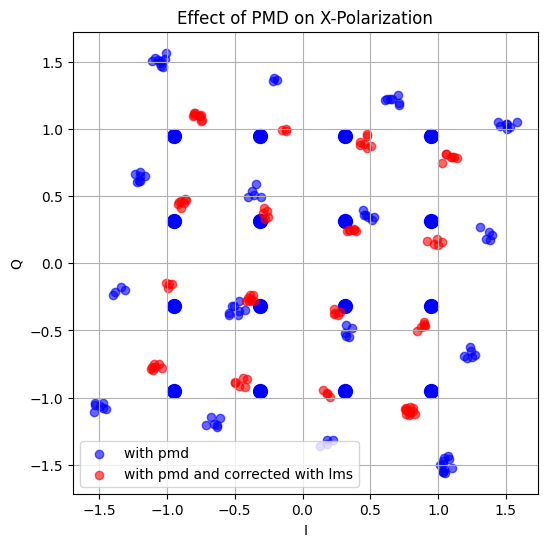

In [102]:
import matplotlib.pyplot as plt
from itertools import product

# Define the symbol values
symbols = [-3, -1, 1, 3]

# Generate all combinations (x, y)
points = np.array(list(product(symbols, repeat=2)))

# Normalize by sqrt(10)
points = points / np.sqrt(10)

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], color='blue', s=100)
plt.scatter(E_in[:, 0].real, E_in[:, 0].imag, color='blue', label='with pmd', alpha=0.6)
plt.scatter(E_out[:, 0].real, E_out[:, 0].imag, color='red', label='with pmd and corrected with lms', alpha=0.6)
plt.xlabel('I')
plt.ylabel('Q')
plt.legend()
plt.title('Effect of PMD on X-Polarization')
plt.grid(True)
plt.show()